# Homework 8

---

### Q1: perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#### Import Data

The following dataset was sourced from Kaggle: https://www.kaggle.com/datasets/marshuu/breast-cancer. Here, the dependent variable is "Class", which classifies tumours as benign (Class 2) or malignant (Class 4). Independent variables include clump thickness, uniformity of cell size, uniformity of cell shape, marginal adhesion, single epithelial cell size, bare nuclei, bland chromatin, normal nucleoli, and mitoses.

In [2]:
data = pd.read_csv('breast_cancer.csv')
data

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1,2
679,2,1,1,1,2,1,1,1,1,2
680,5,10,10,3,7,3,8,10,2,4
681,4,8,6,4,3,4,10,6,1,4


#### Using PyMC to Construct Model

In [7]:
# standardize predictors
X = data[['Clump Thickness', 'Uniformity of Cell Shape', 'Marginal Adhesion',
          'Single Epithelial Cell Size', 'Bare Nuclei',
          'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']]
X = (X - X.mean()) / X.std()

# class in data is 2 or 4. Use boolean to recode to 0 (benign), 1 (malignant)
y = (data['Class'] == 4).astype(int)
p = X.shape[1]

with pm.Model() as model:
    
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    betas = pm.Normal('betas', mu=0, sigma=5, shape=p)
    
    eta = alpha + pm.math.dot(X, betas)
    
    # clipping to avoid errors
    p1 = pm.Deterministic('p1', pm.math.clip(pm.math.sigmoid(eta), 1e-6, 1 - 1e-6))

    y_obs = pm.Bernoulli('y_obs', p=p1, observed=y)
    
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.106,0.329,-1.749,-0.505,0.003,0.002,10884.0,6085.0,1.0
betas[0],1.661,0.423,0.919,2.508,0.004,0.003,9678.0,5813.0,1.0
betas[1],1.063,0.530,0.079,2.085,0.005,0.004,9689.0,5779.0,1.0
betas[2],1.019,0.361,0.352,1.711,0.003,0.003,11798.0,6190.0,1.0
betas[3],0.214,0.364,-0.502,0.872,0.003,0.003,11489.0,6118.0,1.0
betas[4],1.495,0.363,0.791,2.136,0.003,0.002,12700.0,6788.0,1.0
betas[5],1.194,0.426,0.399,1.979,0.004,0.003,12906.0,6282.0,1.0
betas[6],0.696,0.359,0.006,1.350,0.003,0.003,12810.0,5493.0,1.0
betas[7],0.990,0.479,0.090,1.845,0.005,0.004,11271.0,6850.0,1.0


#### Diagnostics

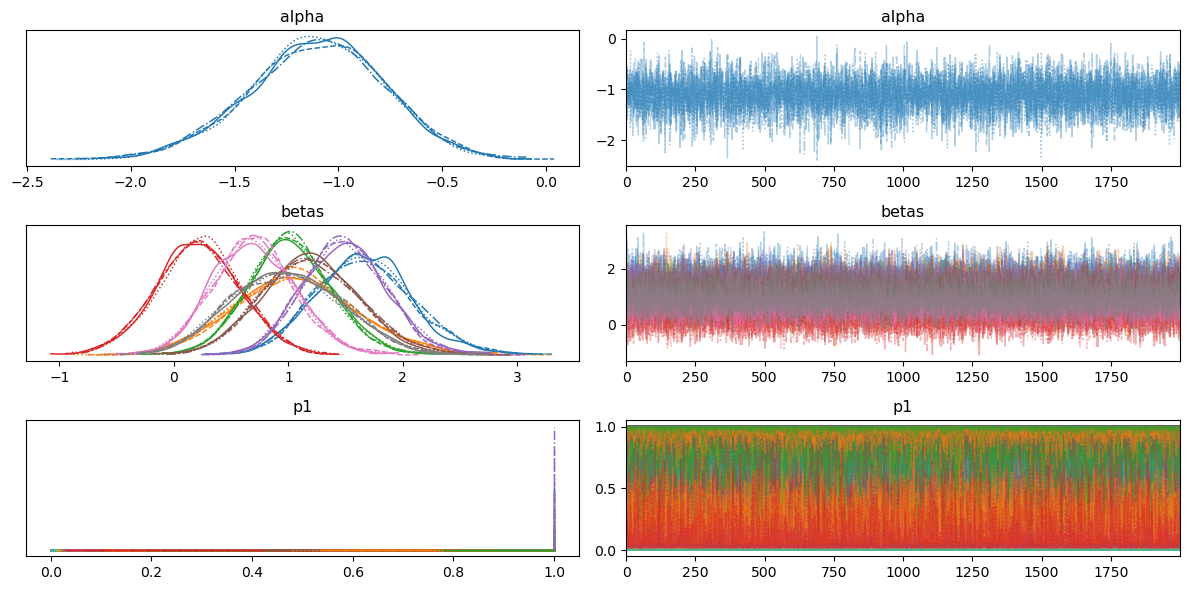

In [8]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

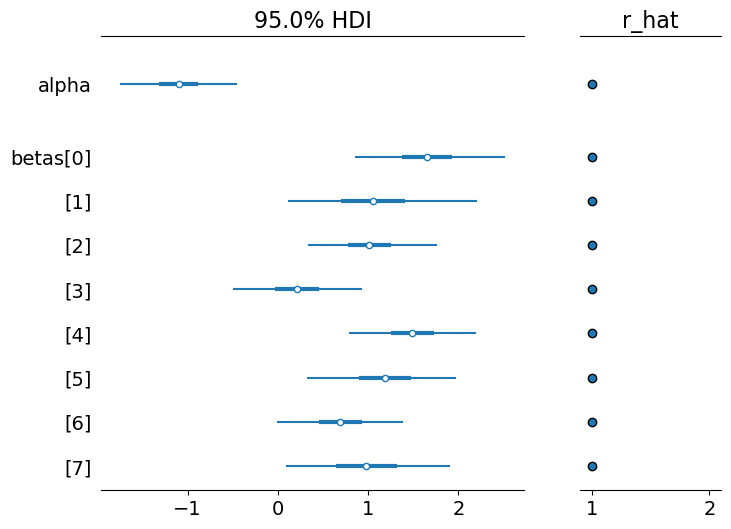

In [10]:
az.plot_forest(trace, var_names=["alpha", "betas"], 
               combined=True, hdi_prob=0.95, r_hat=True);

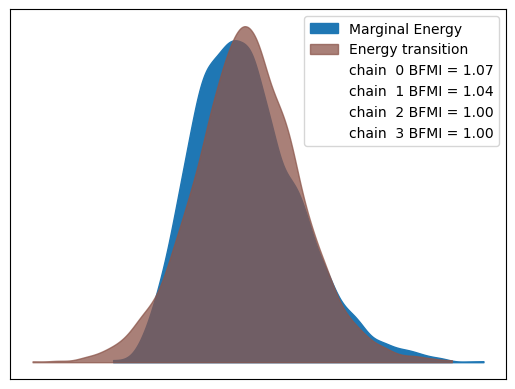

In [11]:
az.plot_energy(trace);

#### Posterior Predictive Checks

Sampling: [y_obs]


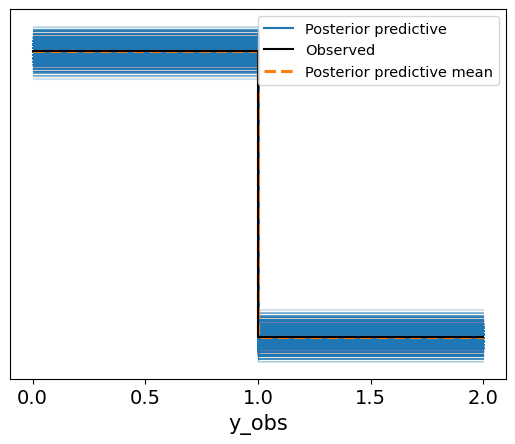

In [12]:
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

az.plot_ppc(ppc)
plt.show()

#### Bayesian Inference

The 94% credible intervals are provided below:

In [14]:
az.summary(trace, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.10632,0.32923,-1.74906,-0.50508,0.00317,0.00241,10884.32364,6085.49225,1.00029
betas[0],1.66064,0.42338,0.91946,2.50830,0.00431,0.00313,9677.99043,5812.92608,1.00120
betas[1],1.06338,0.52999,0.07858,2.08485,0.00541,0.00427,9689.22277,5779.36338,1.00122
betas[2],1.01910,0.36113,0.35164,1.71137,0.00333,0.00254,11797.83483,6190.14317,0.99990
betas[3],0.21381,0.36367,-0.50231,0.87205,0.00339,0.00338,11489.28112,6117.53883,1.00022
...,...,...,...,...,...,...,...,...,...
p1[678],0.00309,0.00220,0.00016,0.00710,0.00002,0.00002,9475.20810,5850.60502,1.00015
p1[679],0.00109,0.00086,0.00004,0.00264,0.00001,0.00001,8636.98012,6636.91130,1.00055
p1[680],0.99429,0.00855,0.98099,0.99999,0.00009,0.00007,10161.46097,7173.85114,1.00016
p1[681],0.95973,0.04869,0.87225,0.99994,0.00051,0.00036,11980.16018,6659.16856,0.99999


#### Discussion and Interpretation

In this problem, we have used logistic regression on the classification of breast cancer tumours, where different variables were used to tell whether a tumour was benign or malignant. In all, the model fits the data well. For example, trace plots mostly demonstrate convergence and consistent mixing across the entire sample. This is also demonstrated in the forest plot, as R-hat values are at 1. The energy plot reveals good overlap between the theoretical and empirical energies. Through posterior predictive sampling, we can see that the model's predictions are close to the observed data's distribution and reproduce the overall shape and spread of the data.

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics



#### Import and prepare dataset

This dataset was sourced from Kaggle: https://www.kaggle.com/datasets/tarunkumar1912/fish-dataset1.
In this model, we will try to predict the weight and height of a fish based on its species, width, and the 3 lengths measured, which are its vertical length (Length1), diagonal length (Length2), and cross length (Length3). All measurements are in centimetres. 

In [2]:
# import data
data2 = pd.read_csv("Fish_dataset.csv")
data2

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [8]:
n_sample = 100
fish_data_sample = fish_data_encoded.sample(n=n_sample, random_state=42)

selected_predictors = ["Length1", "Length2", "Length3", "Width"] + list(fish_data_sample.filter(like="Species_").columns)
X_sample = fish_data_sample[selected_predictors].values

Y_sample = fish_data_sample[["Weight", "Height"]].values

scaler_X = StandardScaler()
X_sample = scaler_X.fit_transform(X_sample)

scaler_Y = StandardScaler()
Y_sample = scaler_Y.fit_transform(Y_sample)

# new dataset dimensions
n, p = X_sample.shape  
m = Y_sample.shape[1] 

#### Using PyMC to Model

In [11]:
#n,m,p = 100,10,5
#beta_ = np.ones((p,m))
# X = stats.norm().rvs((n,p))
#a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()
#x = X@beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)
a_cov = np.cov(Y, rowvar=False)

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=1.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    
    L = pm.expand_packed_triangular(m, packed_L)
    
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    
    y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                    observed=Y)   
    
    idata = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    #idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2127 seconds.


#### Visualizations and Diagnostics

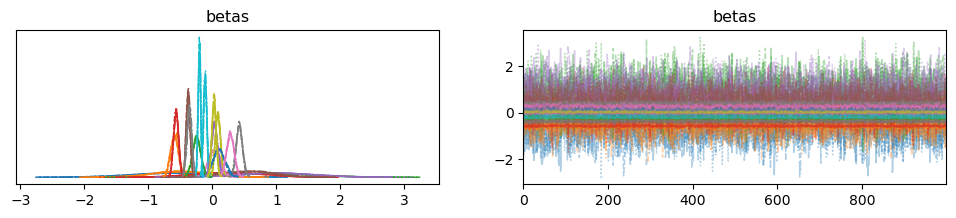

In [12]:
import arviz as az

az.plot_trace(idata,var_names='betas');

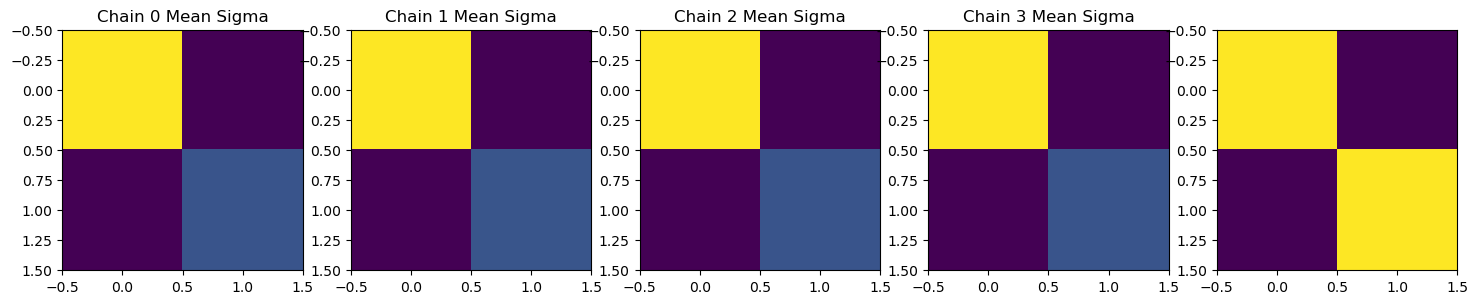

In [13]:
fig,ax = plt.subplots(1,5,figsize=(18,4))
ax[-1].imshow(a_cov)
ax[0].set_title(("Sigma used to generate y"))
for chain in range(4):
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title((f"Chain {chain} Mean Sigma"))

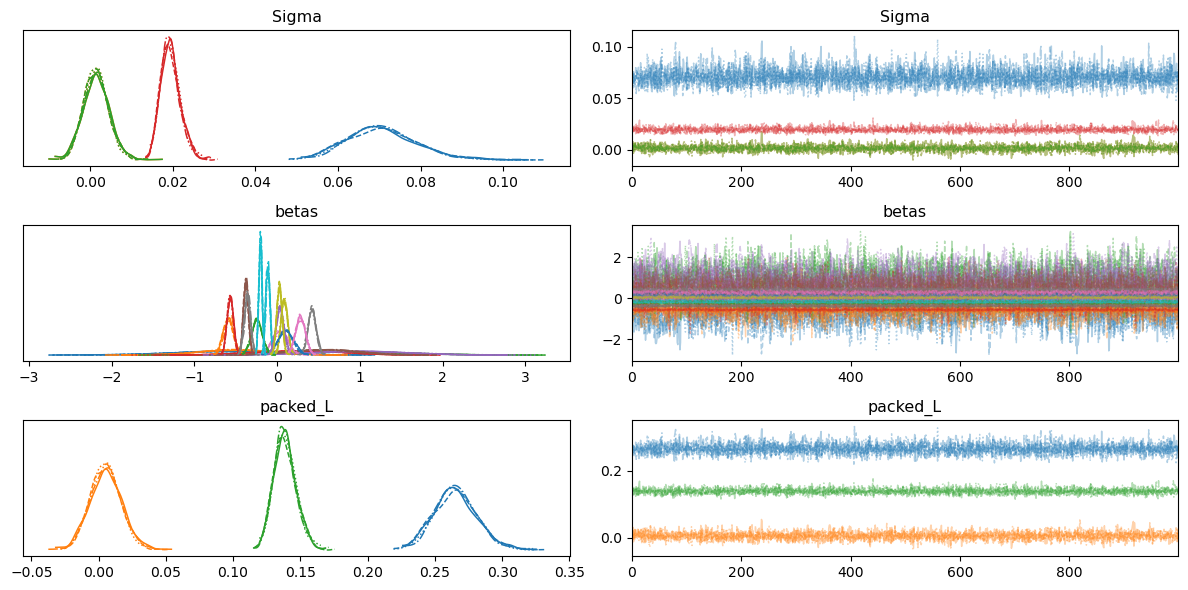

In [14]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

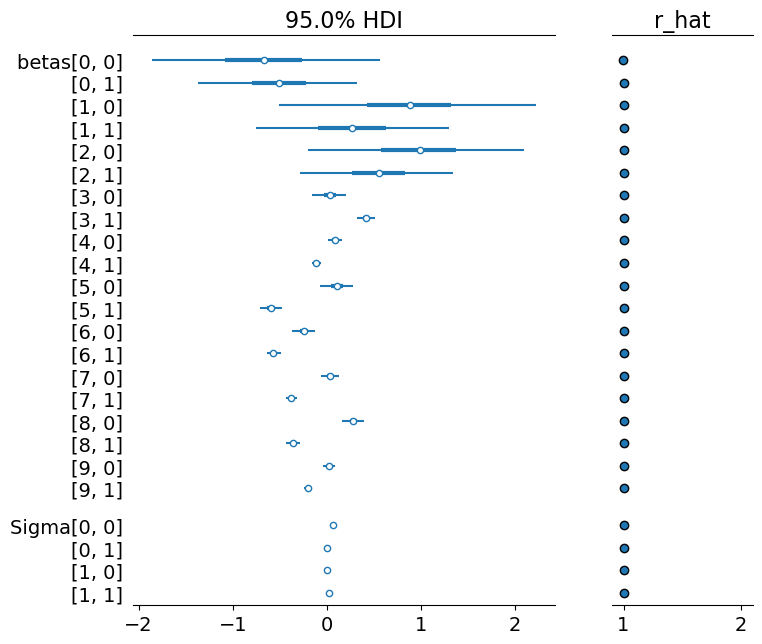

In [15]:
az.plot_forest(idata, var_names=["betas", "Sigma"], 
               combined=True, hdi_prob=0.95, r_hat=True);

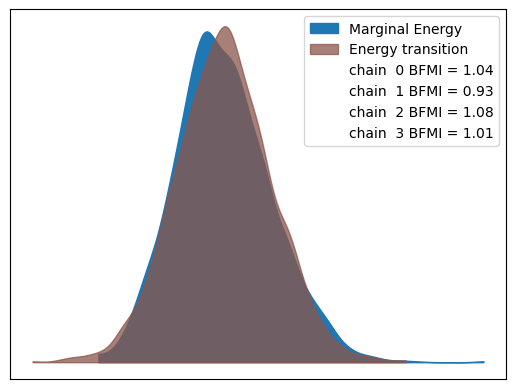

In [16]:
az.plot_energy(idata);

#### Posterior Predictive Checks

Sampling: [y]


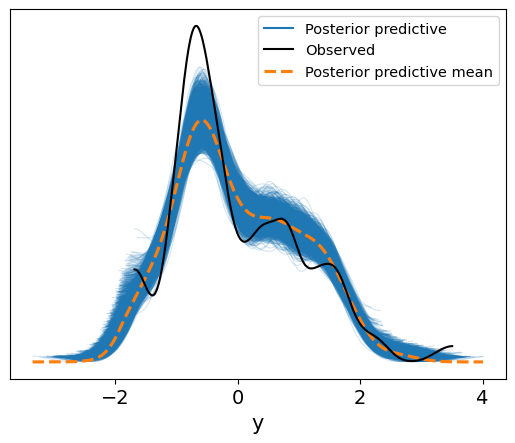

In [17]:
with MNV_LKJ:
    ppc2 = pm.sample_posterior_predictive(idata, random_seed=42)

az.plot_ppc(ppc2)
plt.show()

#### Bayesian Inference

The 94% credible intervals are given below:

In [18]:
az.summary(idata, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.07077,0.00850,0.05545,0.08644,0.00013,0.00015,4320.50995,2833.89418,1.00047
"Sigma[0, 1]",0.00142,0.00310,-0.00444,0.00720,0.00005,0.00006,4115.40312,2684.91038,1.00077
"Sigma[1, 0]",0.00142,0.00310,-0.00444,0.00720,0.00005,0.00006,4115.40312,2684.91038,1.00077
"Sigma[1, 1]",0.01944,0.00236,0.01522,0.02392,0.00004,0.00004,4296.79544,2550.16153,1.00071
"betas[0, 0]",-0.67127,0.61220,-1.85833,0.45662,0.01431,0.00960,1832.54237,2243.53628,0.99972
"betas[0, 1]",-0.51039,0.43016,-1.27721,0.34651,0.00854,0.00679,2535.75172,2749.58232,1.00106
"betas[1, 0]",0.88657,0.68580,-0.30827,2.29710,0.01331,0.01072,2639.87473,2784.50374,1.00082
"betas[1, 1]",0.26358,0.53158,-0.71646,1.24738,0.01057,0.00750,2537.47206,2895.23030,1.00004
"betas[2, 0]",0.97695,0.59732,-0.16759,2.05108,0.01774,0.01093,1133.51358,1883.35116,1.00249
"betas[2, 1]",0.54825,0.41667,-0.22474,1.32117,0.01218,0.00719,1172.40718,1930.30805,1.00578


#### Discussion and Interpretation

In this particular exercise, we are asked to experiment with different values of $n$, $m$, and $p$ in addition to providing Bayesian inference. Here, Bayesian analysis was done with a sample size $n$ of 100 instead of the full dataset. Using the full dataset was computationally expensive and too time-consuming. There were $p$ = 5 predictors and $m$ = 2. Overall, the model fit the data well. MCMC diagnostics show convergence, consistent mixing, and overlapping theoretical and empirical energies. This is confirmed by the posterior predictive checks, where the generated data follows the observed data relatively well.

### Probit Regression (as opposed to Logistic Regression)

- $\Phi$ is CDF of standard normal (and is also call the **inverse probit** function)
    - The **probit** function is $\Phi^{-1}$
- $z_i \sim N(x_i^\top\beta,1)$


$$\int \Phi(z_i)^{y_i} (1-\Phi(z_i))^{1-y_i}d\Phi(z) = \Phi(x_i^\top\beta)^{y_i} (1-\Phi(x_i^\top\beta))^{1-y_i} = p_i^{y_i} (1-p_i)^{1-y_i} $$

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


#### Import and Prepare Data

The following dataset was sourced from Kaggle: https://www.kaggle.com/datasets/yasserhessein/early-stage-diabetes-risk-prediction-dataset.

In [8]:
data3 = pd.read_csv('diabetes_data_upload.csv')
data3

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [72]:
diabetes_data = data3.dropna()

n_sample = 200
diabetes_sample = diabetes_data.sample(n=n_sample, random_state=42)

outcomes = ["class", "sudden weight loss"]
Y_sample = diabetes_sample[outcomes].replace({"Yes": 1, "No": 0, "Positive": 1, "Negative": 0}).astype(int).values

selected_predictors = ["Polyphagia", "Polydipsia", "Obesity", "Polyuria"]

X_sample = diabetes_sample[selected_predictors].replace({"Yes": 1, "No": 0}).astype(float).values

n, p = X_sample.shape  
m = Y_sample.shape[1]  

# check
print(f"Final X_sample Shape: {X_sample.shape}, Final Y_sample Shape: {Y_sample.shape}")


Final X_sample Shape: (200, 4), Final Y_sample Shape: (200, 2)


In [73]:
a_cor = np.corrcoef(Y_sample.T)  

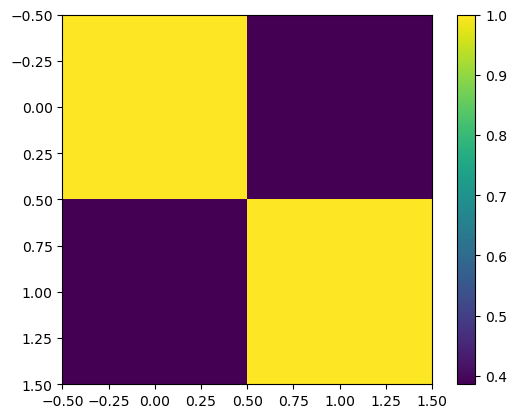

In [74]:
# n,m,p = 100,3,3
# beta_ = np.ones((p,m))
# X = stats.norm().rvs((n,p))
# #a_cov = stats.invwishart(df=m+2, scale=np.ones(m)).rvs()
# a_cor = (np.ones((p,p))+np.diag((1,1,1)))/2
# a_cor[0,-1] = 0.25
# a_cor[-1,0] = 0.25
# x = X@beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar()

# Make outcome binary
# x = x>0

#### Using PyMC to Model

In [83]:
with pm.Model() as GLM:
    
    L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                compute_corr=True)
    
    #L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    
    #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    
    z = pm.MvNormal('z', mu=X_sample @ betas, chol=L) #cov=Sigma
    # the probit is the inverse cdf of a standard normal
    # the inverse probit is the cdf of a standard normal
    
    y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=Y_sample) 
    
    # Integrating out z would give:
    #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
    
    idata2 = pm.sample(1000, tune=1000, target_accept=0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3388 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1031 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


#### Visualizations and Diagnostics

In [84]:
beta_mean = idata2.posterior['betas'].mean(dim=("chain", "draw")).values
beta_mean = beta_mean.reshape(p, m) 

z_pred = X_sample @ beta_mean

invprobit_z = pm.math.invprobit(z_pred).eval()

# check shape outputs
print("z_pred shape:", z_pred.shape)  
print("invprobit_z shape:", getattr(invprobit_z, 'shape', 'scalar'))  

# ensure invprobit_z is 2D
invprobit_z = np.atleast_2d(invprobit_z)

binary_residuals = np.atleast_2d(Y_sample - invprobit_z)
# check shape
print("binary_residuals shape:", getattr(binary_residuals, 'shape', 'scalar'))  

binary_residual_cov = np.cov(binary_residuals.T)
#check shape
print("binary_residual_cov shape:", binary_residual_cov.shape)  

z_pred shape: (200, 2)
invprobit_z shape: (200, 2)
binary_residuals shape: (200, 2)
binary_residual_cov shape: (2, 2)


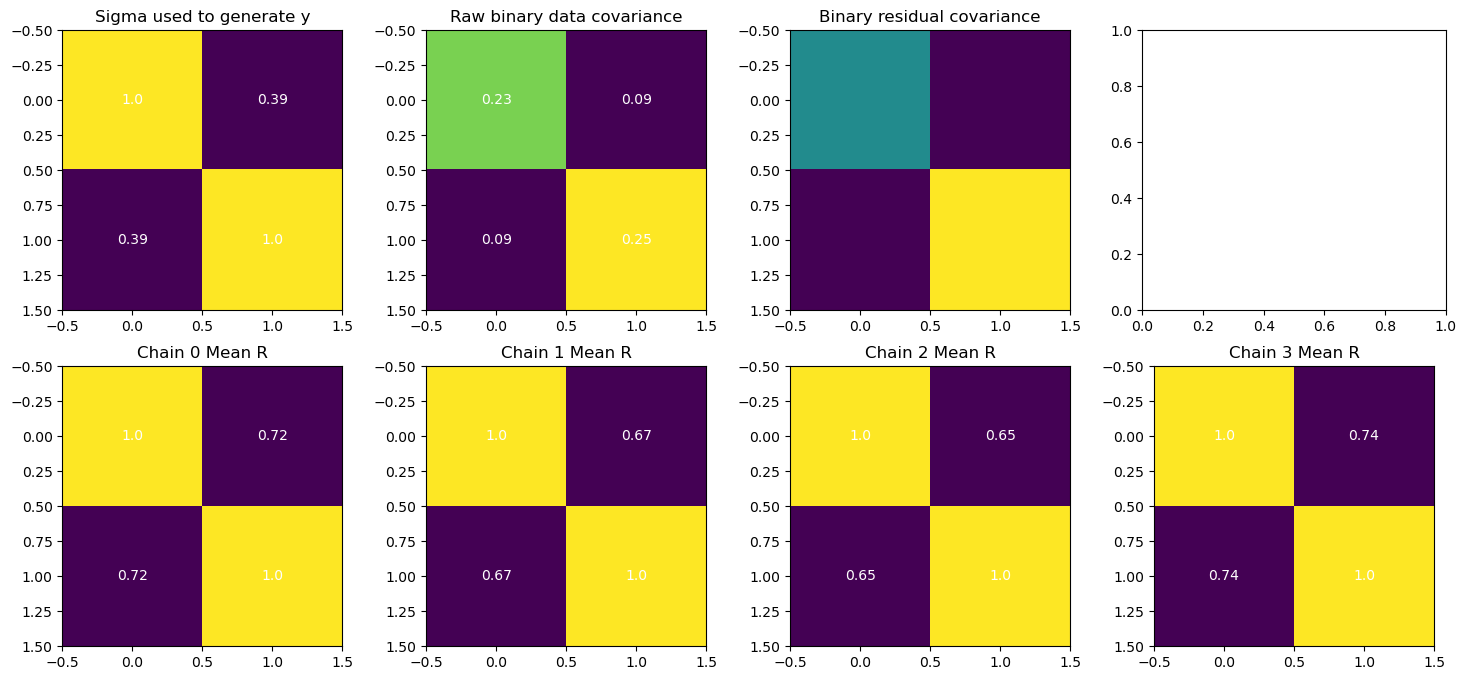

In [90]:
matrix_size = a_cor.shape[0]
n_chains = idata2.posterior['R_corr'].mean(axis=1).shape[0]  

fig, ax = plt.subplots(2, 4, figsize=(18, 8))

ax[0, 0].imshow(a_cor)
ax[0, 0].set_title("Sigma used to generate y")
for i in range(matrix_size):
    for j in range(matrix_size):
        ax[0, 0].text(i, j, str(round(a_cor[j, i], 2)),
                      c='w', ha='center', va='center')

ax[0, 1].imshow(binary_cov)
ax[0, 1].set_title("Raw binary data covariance")
for i in range(matrix_size):
    for j in range(matrix_size):
        ax[0, 1].text(i, j, str(round(np.cov(Y_sample.T)[j, i], 2)),
                      c='w', ha='center', va='center')

ax[0, 2].imshow(binary_residual_cov)
ax[0, 2].set_title("Binary residual covariance")

for chain in range(n_chains):  
    ax[1, chain].imshow(idata2.posterior['R_corr'].mean(axis=1)[chain])
    for i in range(matrix_size):
        for j in range(matrix_size):
            ax[1, chain].text(i, j, str(round(idata2.posterior['R_corr'].mean(axis=1)[chain].values[j, i], 2)),
                              c='w', ha='center', va='center')
    ax[1, chain].set_title(f"Chain {chain} Mean R")

plt.show()


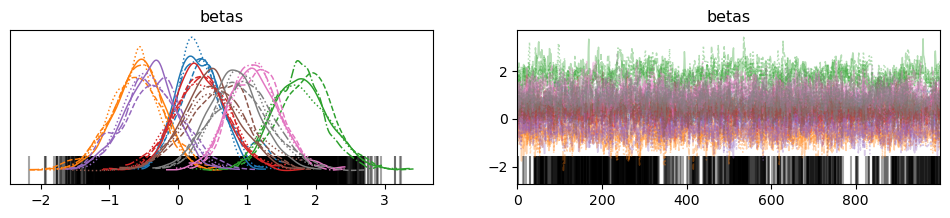

In [91]:
az.plot_trace(idata2,var_names='betas');

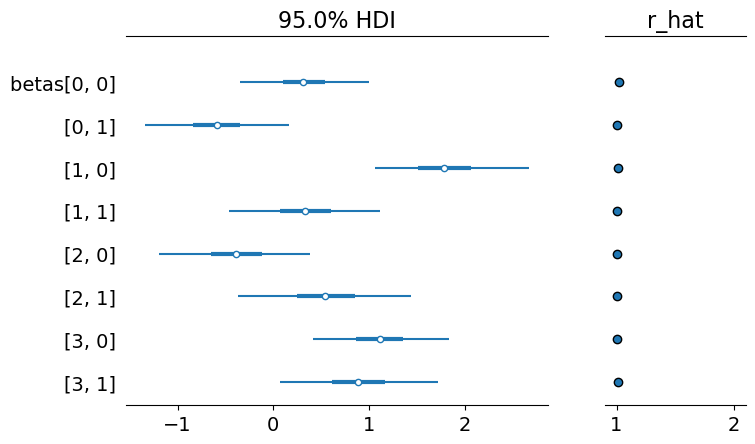

In [92]:
az.plot_forest(idata2, var_names=["betas"], 
               combined=True, hdi_prob=0.95, r_hat=True);

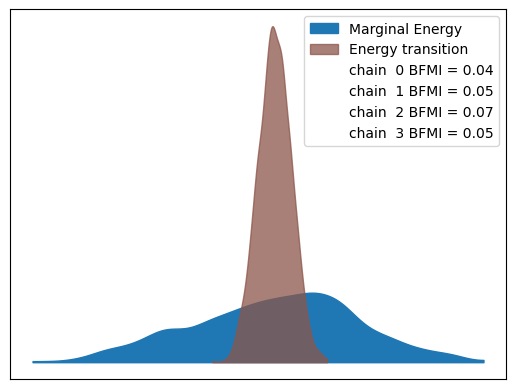

In [93]:
az.plot_energy(idata2);

#### Post Predictive Checks

Sampling: [y]


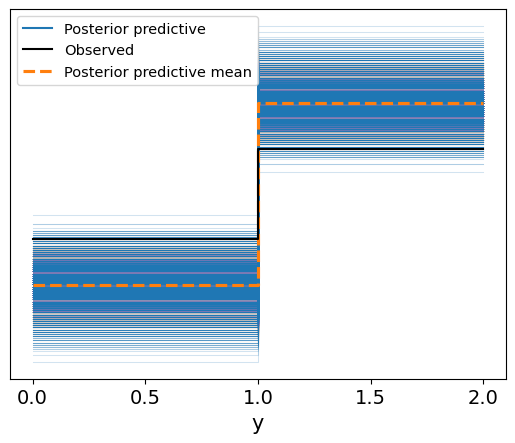

In [94]:
with GLM:
    ppc3 = pm.sample_posterior_predictive(idata2, random_seed=42)

az.plot_ppc(ppc3)
plt.show()

#### Bayesian Inference

The 94% credible intervals are provided below:

In [95]:
az.summary(idata2, var_names=["betas"], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.33156,0.34179,-0.34499,0.92535,0.01912,0.01749,370.39632,212.74964,1.01588
"betas[0, 1]",-0.60139,0.38380,-1.30758,0.14051,0.01415,0.01151,743.61822,486.91512,1.00557
"betas[1, 0]",1.79547,0.41268,1.04490,2.59316,0.02578,0.01053,254.97966,845.24360,1.01082
"betas[1, 1]",0.34097,0.40124,-0.40103,1.11027,0.01188,0.00696,1149.54531,1875.63095,1.00321
"betas[2, 0]",-0.38844,0.40438,-1.14247,0.37411,0.01611,0.00947,635.92388,637.52454,1.00606
"betas[2, 1]",0.54542,0.45506,-0.31592,1.40786,0.01821,0.01235,628.55644,458.23515,1.00858
"betas[3, 0]",1.11294,0.36546,0.46917,1.82177,0.01823,0.00962,408.17148,802.98467,1.00273
"betas[3, 1]",0.89592,0.42040,0.13057,1.71330,0.02025,0.01084,440.80184,661.30211,1.01092


#### Discussion and Interpretation

This dataset focuses on diagnosing diabetes based on a variety of different symptoms, such as polyuria (excessive urine production), polyphagia (incessant hunger), polydipsia (excessive thirst), obesity, and many other conditions. In this analysis, the "Class" and "Sudden Weight Loss" variables were chosen as outcome variables ($m$ = 2), while "Polyphagia", "Polydipsia", "Obesity", and "Polyuria" were chosen as the predictor variables ($p$ = 4). A sample size $n$ = 200 was used. Overall, the model has several problems that should be addressed in future analyses but could not be resolved due to time constraints. Sampling revealed many divergences. Energy plots show significant disparities between the theoretical and empirical energies. As well, trace plots show problems with convergence in addition to inconsistent mixing.